# Data Exploration and Cleaning

This notebook will demonstrate me exploring the dataset and preparing the data.

In [1]:
%matplotlib inline
import boto3
import sagemaker
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

## Downloading the Data

These upcoming coding cells will download the data into your current working directory of where this notebook is placed.<br>

I will use Kaggle's API to download the dataset.

Thanks to Freddie Kalborn for posting this short tutorial for downloading the data using SageMaker. Check it out <a href=https://freddiek.github.io/2018/06/10/accessing-Kaggle-from-SageMaker-instance.html>here</a>.<br>

Read the readme of Kaggle API repo <a href=https://github.com/Kaggle/kaggle-api>here</a> for me directions.<br>

**Also, please upload your kaggle.json file to this path: /home/ec2-user/SageMaker/ to download the data**

In [3]:
%%bash
pip install kaggle

# Move API key to where Kaggle expects it
mv /home/ec2-user/SageMaker/kaggle.json /home/ec2-user/.kaggle

# Download datasets, optionally specify destination folder using --path
kaggle datasets download coldestadam/chest-xray-pneumonia -w --unzip

fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
mv: cannot stat ‘/home/ec2-user/SageMaker/kaggle.json’: No such file or directory
100%|██████████| 1.14G/1.14G [00:16<00:00, 73.7MB/s]


## Loading the images

Here I will use the <a href=https://docs.python.org/3.6/library/glob.html>glob</a> and <a href=https://docs.python.org/3.6/library/pathlib.html#module-pathlib>pathlib</a> libraries. These libraries will allow me to get a list of all the pathways to jpeg images.

In [4]:
import glob
from pathlib import Path
data_dir = Path(os.path.join(os.getcwd(), 'chest_xray'))
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'

In [5]:
type(data_dir)

pathlib.PosixPath

Now creating different Path objects for the training, testing, and validation folders, I will gather all the pathways to each of the images in those folders.

In [6]:
#I will first gather the pathways of all the training images
train_NORMAL_dir = train_dir / 'NORMAL'
train_PNEUMONIA_dir = train_dir / 'PNEUMONIA'

train_NORMAL_images = train_NORMAL_dir.glob('*.jpeg')#'*.jpeg' means that it would gather all the jpeg files.
train_PNEUMONIA_images = train_PNEUMONIA_dir.glob('*.jpeg')

In [7]:
type(train_NORMAL_images)

generator

Here we see that glob returns a generator of all the pathways of the images, we can convert these generators into lists.

In [8]:
train_NORMAL_images = list(train_NORMAL_images)
train_PNEUMONIA_images = list(train_PNEUMONIA_images)

Now after converting them, we can look inside and see what is in the list.

In [9]:
train_NORMAL_images[0]

PosixPath('/home/ec2-user/SageMaker/ML_SageMaker_Studies/Capstone_Project/chest_xray/train/NORMAL/IM-0652-0001-0002.jpeg')

From above, we see that each element in the lists are Path objects of single images. When we will manipulate the dataset later on, we can convert each of these Path objects to string values that will provide us with the pathway to a single image in the string format. I will demonstrate that below:

In [10]:
str(train_NORMAL_images[0])

'/home/ec2-user/SageMaker/ML_SageMaker_Studies/Capstone_Project/chest_xray/train/NORMAL/IM-0652-0001-0002.jpeg'

Now after displaying that, I will do the same for the test and val folders!

In [11]:
test_NORMAL_dir = test_dir / 'NORMAL'
test_PNEUMONIA_dir = test_dir / 'PNEUMONIA'
val_NORMAL_dir = val_dir / 'NORMAL'
val_PNEUMONIA_dir = val_dir / 'PNEUMONIA'

test_NORMAL_images = test_NORMAL_dir.glob('*.jpeg')
test_PNEUMONIA_images = test_PNEUMONIA_dir.glob('*.jpeg')
val_NORMAL_images = val_NORMAL_dir.glob('*.jpeg')
val_PNEUMONIA_images = val_PNEUMONIA_dir.glob('*.jpeg')

#Converting the generators into lists
test_NORMAL_images = list(test_NORMAL_images)
test_PNEUMONIA_images = list(test_PNEUMONIA_images)
val_NORMAL_images = list(val_NORMAL_images)
val_PNEUMONIA_images = list(val_PNEUMONIA_images)

# Exploring Data


I will first look at the first image in the training set and see what is its size.

In [12]:
#I will use the Pillow library to look at our image data
from PIL import Image
normal_image = str(train_NORMAL_images[0])
im = Image.open(normal_image)

The size of the image(width, length): (1512, 1237)
These are the dimensions of the image: (1237, 1512)


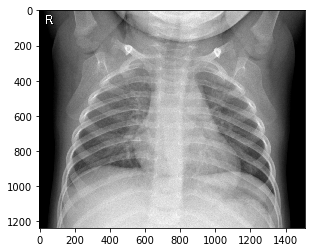

In [13]:
#I will use the imshow function from matplotlib to print the image
from matplotlib.pyplot import imshow
image_array = np.asarray(im)
print("The size of the image(width, length):", im.size)
print("These are the dimensions of the image:", image_array.shape)
imshow(image_array, cmap='gray')

In [14]:
print('The maximum integer in a pixel:', image_array.max())
print('The minimum integer in a pixel:', image_array.min())

The maximum integer in a pixel: 255
The minimum integer in a pixel: 0


The image above is labeled as not having pneumonia. <br>
The length of the image: 1237 pixels <br>
The width of the image: 1512 pixels <br>

<b>The image is a grayscale image since the brightness range is (0, 255)</b><br>
To read more about this, you can refer to this <a href=https://www.whydomath.org/node/wavlets/imagebasics.html>here</a>.<br>

Shorter Explanation:<br>
<b>Black</b> is symoblized by 0.<br>
<b>White</b> is symbolized by 255.<br>
Integers within the range are different gray gradients.

Since discovering the dimensions of the image, my next step will be to compare the dimensions of the image with another random one.<br>
<b>This is important because our images must have the same dimensions to pass through Convolutional Neural Network</b><br>

I will choose the first image with pneumonia in the test set

The size of the image(width, length): (1272, 813)
These are the dimensions of the image: (813, 1272)


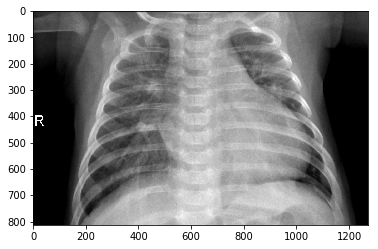

In [15]:
#First image that has pneumonia in the test set
second_image = str(test_PNEUMONIA_images[0])
im2 = Image.open(second_image)
image_array2 = np.asarray(im2)
print("The size of the image(width, length):", im2.size)
print("These are the dimensions of the image:", image_array2.shape)
imshow(image_array2, cmap='gray')

## Issue!
The length of the first image is 1237 pixels.<br>
The width of the first image is 1512 pixels.<br>

The length of the second image is 813 pixels.<br>
The width of the second image is 1272 pixels.<br>

<b>This is an issue since the dimensions of these images do not align!</b><br>

Therefore image transformations must take place before being inputted into the network.

(Some libraries such as PyTorch include built-in image transformations, but I think it would be best to have a unified and static dataset for all my models to use)

## Are all images greyscale images?

The two images above are both greyscale images, but we do not know if all of them are greyscale. I will create a function below that will check all the images below.

BUT first I will explain the intuition.

First I will upload an RGB image, and load it in with the <a href=https://pillow.readthedocs.io/en/stable/index.html>Pillow</a> library as above.

I referred to this stackoverflow page for help <a href=https://stackoverflow.com/questions/7391945/how-do-i-read-image-data-from-a-url-in-python>here</a>.

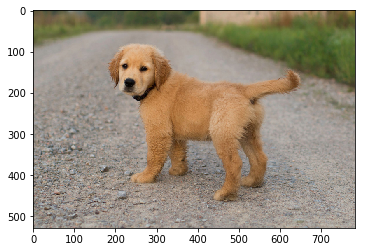

In [16]:
import requests
from io import BytesIO
url = 'https://boygeniusreport.files.wordpress.com/2016/11/puppy-dog.jpg?quality=98&strip=all&w=782'
dog_image = requests.get(url)
dog_image = Image.open(BytesIO(dog_image.content))

imshow(dog_image)

In [17]:
dog_image_array = np.asarray(dog_image)
dog_image_array.shape

(529, 782, 3)

**Length of image:** 529<br>
**Width of image:** 782<br>
**Depth of image:** 3

An RGB image is a 3-D array that containts 3 2-D arrays attached to eachother. A good representation would be a cube. <br>
Each 2-D array contains the pixel values of a certain color.<br>

First 2-D array contains the pixel values for **Red**<br>
Second 2-D array contains the pixel values for **Green**<br>
Third 2-D array contains the pixel values for **Blue**

In [18]:
#This is the pixel values for the color red
dog_red = dog_image_array[:, :, 0]
dog_red.shape

(529, 782)

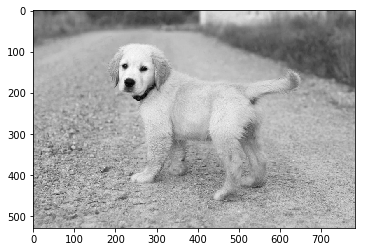

In [19]:
#As I print it, you can see its just a grayscale image.
imshow(dog_red, cmap='gray')

In [20]:
#I can conform it using what will be shown next
Image.fromarray(dog_red).mode

'L'

The Pillow library provides a great instance attribute to their Image class called **mode**.<br>
We can use **mode** since it returns an 'L' if it is a greyscale image and 'RBG' if it is a RBG image.<br>
Ypu can read more about it <a href=https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes>here</a>.

In [21]:
dog_image.mode

'RGB'

In [22]:
im2.mode

'L'

Now understanding RGB images and how to check if the images are either RGB or greyscale, I can create the function to check all images.

In [23]:
def RGB_Count(image_lists):
    """
    Gives the total number of RGB images in the dataset
    
    Parameters:
    image_lists (list): This is a list of the lists that contains the pathways to all images
    
    Returns:
    RGB_count (int): The number of RGB images in the dataset
    """
    RGB_count=0
    for image_list in image_lists:
        for image_path in image_list:
            #Converting the Path object to a string value of the path
            path = str(image_path)
            #Creating an Image object and checking if its mode is 'RGB'
            if Image.open(path).mode == 'RGB':
                RGB_count+=1
    return RGB_count

In [24]:
lists = [train_NORMAL_images, train_PNEUMONIA_images, test_NORMAL_images, test_PNEUMONIA_images, 
        val_NORMAL_images, val_PNEUMONIA_images]
RGB_Count(lists)

283

There are a total of 566 RGB images in the dataset, so not all images are not uniform in their 'depth' as discussed above.<br>
So when we transform our data, we must decide whether to make all images into grayscale or RGB images to make the dataset uniform.

## Is our training data balanced?
Let's see...

In [25]:
n_normal = len(train_NORMAL_images)
n_pneumonia = len(train_PNEUMONIA_images)
print('The number of normal images in the training set:', n_normal)
print('The number of images with pneumonia in the training set:', n_pneumonia)

The number of normal images in the training set: 1341
The number of images with pneumonia in the training set: 3875


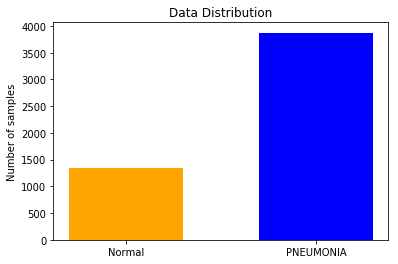

In [26]:
plt.bar(height=[n_normal, n_pneumonia], x=['Normal', 'PNEUMONIA'], width=0.6, color=['orange', 'blue'])
plt.title('Data Distribution')
plt.ylabel('Number of samples')
plt.show()

In [27]:
print('Percentage of normal images in the entire dataset:', 1341/3875)

Percentage of normal images in the entire dataset: 0.3460645161290323


We see here that our training data is VERY Unbalanced.<br>

This is a problem because our model will train on images with pneumonia more than normal images. It can skew our results by there being a less probable chance that it would recognize normal images.<br>

However, we have 1,341 normal images which is quite a lot. So it might not be as huge of an issue if our dataset was smaller, but its still an issue since only 35% of the training set are normal images.

Please read <a href=https://towardsdatascience.com/deep-learning-unbalanced-training-data-solve-it-like-this-6c528e9efea6>this</a> if you want to learn more.

# Data Transformation

Transformations:
    1. Convert all grayscale images to RGB images.
    2. Resize all images to 224x224
    
First, I will go through the intuition and code of making the transforms on one image. Then, I will create a function that will transform the entire dataset.

## Converting grayscale images to RGB

I will use the first image that I used in the beginning attached to variable 'im'

Color: L


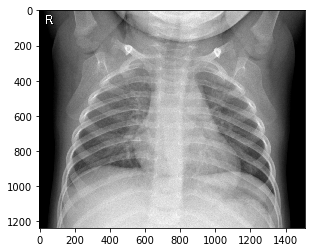

In [28]:
#This is the image
image_array = np.asarray(im)
print("Color:",im.mode)
imshow(image_array, cmap='gray')

Color: RGB
Dimensions of the image: (1237, 1512, 3)


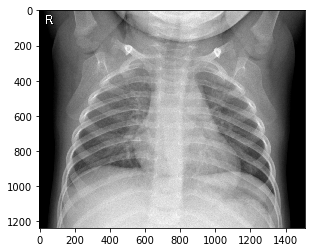

In [29]:
#This is where I will convert the image and save it to variable 'imConvert'
imConvert = im.convert('RGB')
#Converting the Image Object to a Numpy array
imConvert_array = np.asarray(imConvert)
print("Color:", imConvert.mode)
print("Dimensions of the image:", imConvert_array.shape)
imshow(imConvert_array)

From above, I was able to convert the grayscale image to a RGB image that adds 3 depths for the three color channels.

## Resizing the image
I will continue to use the converted image from above

I will use the Image Object's method named *resize()*, documentation is <a href=https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.resize>here</a>.

Dimensions of the image: (224, 224, 3)


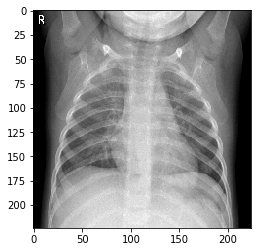

In [30]:
#Here I use the Image Object's method named resize
Resized_imConvert = imConvert.resize((224,224))
Resized_imConvert_array = np.asarray(Resized_imConvert)
print("Dimensions of the image:", Resized_imConvert_array.shape)
imshow(Resized_imConvert_array)

As you see above, the original grayscale image was converted the RGB color-scheme and resized to a 224x224 image.

## Creating the function

In [31]:
def clean_data(image_list, dataFolder, ClassName, rootFolder='clean_data'):
    """
    Reads images from the unclean dataset, then cleans the images and creates a new directory.
    
    Parameters:
    image_list (list): This is a list that contains the pathways to all the unclean images in a single folder
                       dataFolder
    
    dataFolder (string): This is a string that will be used to create a directory that will contain the directories
                         of the labels. (ex. train, test, val)
    
    ClassName (string): This is a string that will be used to create a directory that will be used to label the data.
                        This directory will be inbedded into the dataFolder directory above(ex. NORMAL, PNEUMONIA)
                        
    rootFolder (string): This is a string that will be used to create the root folder of all the directories. It is
                         automatically set to 'clean_data' because for the directory to be clear.
    """
    #First: I will check if rootFolder 'clean_data' exists, if not I will create the directory
    if not os.path.exists(rootFolder):
        os.mkdir(rootFolder)
        
    #Second: I will check if rootFolder/dataFolder exists, if not I will create the directory
    if not os.path.exists(os.path.join(rootFolder, dataFolder)):
        os.mkdir(os.path.join(rootFolder, dataFolder))
    
    #Third: I will check if rootFolder/dataFolder/FolderName exists, if not I will create the directory
    if not os.path.exists(os.path.join(rootFolder, dataFolder, ClassName,)):
        os.mkdir(os.path.join(rootFolder, dataFolder, FolderName))
    
    #Here is the full path where we will save the images
    save_path = os.path.join(rootFolder, dataFolder, ClassName)
    
    #I am going to change the current working directory to the save path, but first I will save the original directory
    orig_path = os.getcwd()
    os.chdir(save_path)
    
    #This is the logic for converting, resizing and saving the image
    image_labeler = 1
    for image_path in image_list:
        path = str(image_path)
        image = Image.open(path)
        #If the image is grayscaled, it will convert in into a RGB image
        if image.mode == 'L':
            image = image.convert('RGB')
        #This resizes the image to 224x224
        image = image.resize((224, 224))
        
        #This will create a specific image name such as 'train_NORMAL_1.jpeg' 
        ImageName = dataFolder + "_" + ClassName + '_{}.jpeg'.format(image_labeler)
        image_labeler+=1
        
        #This is where I save the image in the the path we have chosen
        image.save(ImageName)
    
    #Change the current working directory back to the original path
    os.chdir(orig_path)

# Data Transformation

Here I will clean all the data and create a new folder in the current working directory called 'clean_data' that will have the same organization of unclean data in 'chest_data'.

In [32]:
#Cleaning the rest of the data
clean_data(train_NORMAL_images, dataFolder='train', FolderName='NORMAL')
clean_data(train_PNEUMONIA_images, dataFolder='train', FolderName='PNEUMONIA')
clean_data(test_NORMAL_images, dataFolder='test', FolderName='NORMAL')
clean_data(test_PNEUMONIA_images, dataFolder='test', FolderName='PNEUMONIA')
clean_data(val_NORMAL_images, dataFolder='val', FolderName='NORMAL')
clean_data(val_PNEUMONIA_images, dataFolder='val', FolderName='PNEUMONIA')

# Upload Data to S3
I will upload clean_data to AWS's cloud storage called S3 so it can use the uploaded data to train our models. I will use the upload_data method of the Session object, you can read more about it <a href=https://sagemaker.readthedocs.io/en/stable/session.html#sagemaker.session.Session.upload_data>here</a>.

In [33]:
data_dir = 'clean_data'
prefix = 'capstone_data'

sagemaker_session.upload_data(bucket=bucket, path=data_dir, key_prefix=prefix)

's3://sagemaker-us-east-2-991170486756/capstone_data'

The data was uploaded into my local S3 bucket using the path from above.

# Up Next: Structure, Train and Test Models

But before that, we will delete all the files in our instance to save more space.

In [34]:
#WE WILL DELETE ALL DATA IN OUR CURRENT DIRECTORY
#DO NOT RUN IF YOU DON'T WANT THE DATA DELETED

! rm -r clean_data
! rm -r chest_xray